# SHAP analysis

The jupyter notebook for shap analysis of a surrogate model based on model 1's result

In [1]:
# general
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.model_selection import KFold, cross_validate, train_test_split

# skopt
import skopt
from skopt import gp_minimize
from skopt.callbacks import CheckpointSaver, DeltaYStopper
from skopt.space import Integer, Real
from skopt.utils import use_named_args

random_state = 42
data_df = pd.read_csv('result/model_1_result.csv')

data_df.drop('PU_label', axis = 1, inplace = True)
data_df['pu_prediction'] = data_df['synth_score'].apply(lambda score: 1 if score > 0.562 else 0)

X = data_df.iloc[:, 7:-2]
y = data_df.iloc[:,-1]

model = LGBMClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify= y)

search_space = [Real(0.01, 0.1, name='lambda_l1', prior='log-uniform'),
                Real(0.1, 0.9, name='bagging_fraction'),
                Integer(1,20, name = 'bagging_freq'),
                Integer(2,120, name = 'num_leaves'),
                Real(0.1, 0.9, name = 'feature_fraction'),
                Integer(2,60, name = 'max_depth'),
                Integer(10,200, name = 'max_bin'),
                Real(0.001, 1, name = 'learning_rate', prior='log-uniform'),
                Integer(2, 100, name = 'min_data_in_leaf')]

@use_named_args(search_space)

def evaluate_model(**params):

    print(', '.join(['{}={!r}'.format(k, v) for k, v in params.items()]))

    kf = KFold(n_splits=10, random_state=random_state, shuffle=True)
    model = LGBMClassifier(**params, device = 'gpu', random_state=random_state, verbosity=-1, is_unbalance = True, gpu_use_dp = True)

    score = cross_validate(model, X_train, y_train, cv = kf, n_jobs= 4,
                           scoring = {'roc_auc': make_scorer(roc_auc_score, needs_proba = True)}, verbose = 2)

    print(-score['test_roc_auc'].mean())
    return -score['test_roc_auc'].mean()

# setup checkpoint and early stopping criterion
checkpoint_saver = CheckpointSaver('checkpoint/model_surrogate_lbgm.pkl')
early_stop = DeltaYStopper(0.01, 20)

Run hyperparameter tuning (Only need to run once)

In [ ]:
result = gp_minimize(func = evaluate_model,
                     dimensions = search_space,
                     n_calls = 100,
                     n_initial_points = 10,
                     callback=[checkpoint_saver, early_stop],
                     random_state = random_state)

Import result from checkpoint file once gp_minimize is finished, then use the best hyperparameters to train the shap model.

In [2]:
result = skopt.load('checkpoint/model_surrogate_lbgm.pkl')

model_shap = LGBMClassifier(
    lambda_l1=result.x[0],
    bagging_fraction=result.x[1],
    bagging_freq=result.x[2],
    num_leaves=result.x[3],
    feature_fraction=result.x[4],
    max_depth=result.x[5],
    max_bin=result.x[6],
    learning_rate=result.x[7],
    min_data_in_leaf=result.x[8],
    device = 'gpu',
    random_state=random_state,
    gpu_use_dp = True).fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.35725178829438187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35725178829438187
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l1 is set=0.04337571787222755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04337571787222755
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


Checking shap model performance

In [3]:
y_pred_proba = model_shap.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

g_mean_list = np.sqrt(tpr * (1 - fpr))
ix = np.nanargmax(g_mean_list)

roc_auc = roc_auc_score(y_test, y_pred_proba)

opt_threshold = thresholds[ix]

print('FPR: ',fpr[ix], 
'\nTPR: ', tpr[ix], 
'\nDecision threshold: ', thresholds[ix], 
'\nG-mean', g_mean_list[ix], 
'\nROC AUC', roc_auc)

FPR:  0.1181640625 
TPR:  0.8616187989556136 
Decision threshold:  0.23722226365504515 
G-mean 0.8716687566642776 
ROC AUC 0.937515298629243


Create shap explainer

In [4]:
explainer = shap.Explainer(model_shap)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Check the top 10 most important features

In [5]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(10)

,col_name,feature_importance_vals
139,avg ionic char,3605.340593
85,MagpieData avg_dev CovalentRadius,1256.833635
141,min_oxide_melt,1242.871819
82,MagpieData maximum CovalentRadius,1046.765462
142,mean_oxide_melt,1024.549912
74,MagpieData mean Column,755.123798
119,MagpieData mean NpUnfilled,720.932670
61,MagpieData avg_dev MendeleevNumber,697.338045
120,MagpieData avg_dev NpUnfilled,685.810062
79,MagpieData mean Row,684.135113


Shap summary plot

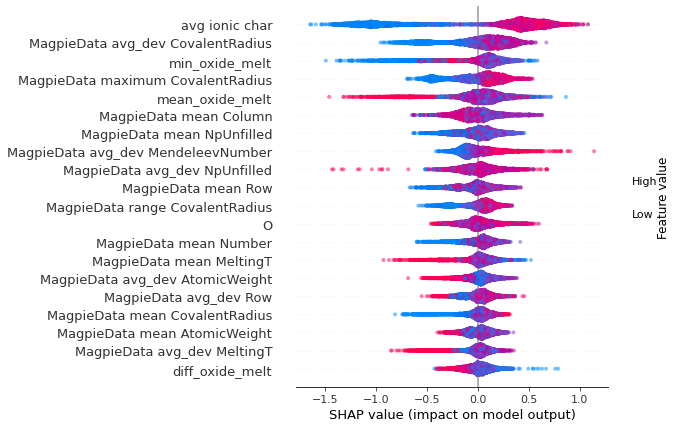

In [6]:
shap.summary_plot(shap_values[1], X_train, max_display = 20, show = False, plot_size = (7,7), alpha = 0.5)